# pmdarima 

```pmdarima``` is a python library that offers ARIMA models and time series statistical tests
## 0. Preliminaries
First, we load libraries and data for our analysis.

In [1]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_series
import pandas as pd
from pmdarima.arima.stationarity import ADFTest


For this tutorial, we will work with the Lynx dataset. It records the number of skins of predators (lynx) that were collected over many years by the Hudson’s Bay Company (1821 - 1934). It’s commonly used for time-series benchmarking (Brockwell and Davis - 1991) and is built into R. The dataset exhibits a clear 10-year cycle.

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

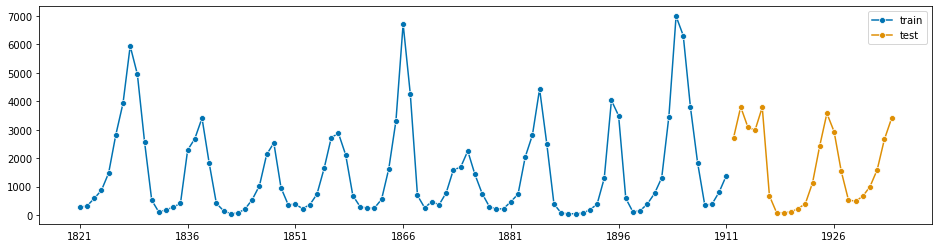

In [2]:
y = pm.datasets.load_lynx(True)
train, test = train_test_split(y, train_size=int(len(y)*0.8))
plot_series(train, test, labels=["train", "test"])

## 1. Autoarima

The main strength of this library is the ```auto_arima``` function, that automatically discovers the optimal order for an ARIMA model.

In [3]:

# Fit your model
model = pm.auto_arima(train, seasonal=True, m = 10)

# make your forecasts
forecasts = model.predict(test.shape[0])  # predict N steps into the future

In [4]:
forecast = pd.Series(forecasts, index=test.index)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

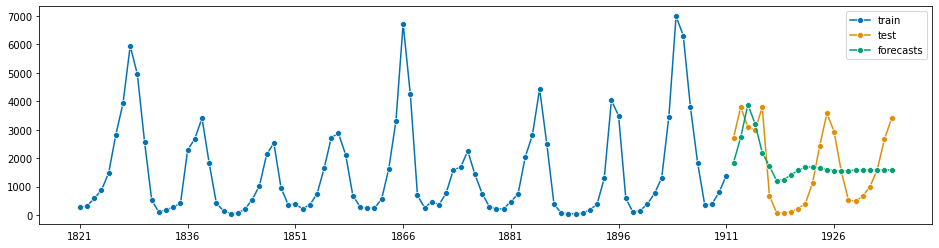

In [5]:
plot_series(train, test, forecast, labels=["train", "test", "forecasts"])

## 2. Statistical tests

```pmdarima``` offers a set of tools related to ARIMA models to detect statistical properties of time series. However, the mantainer of the library recommends not to use them as they are ment for internal use and they are not so reliable as those in the ```statsmodels``` library.

I tried some of them...


Here is one example where the results of ADFTest are incoherent from my point of view, as both results are non-stationarity.

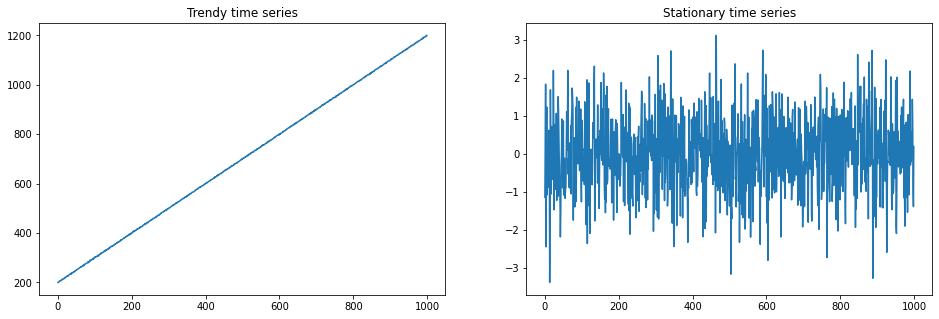

In [6]:
a, b = 0.5, 100
y1 = a*np.arange(0,1000)+b
noise = np.random.normal(y1)
y1 = y1 + noise
y2 = np.random.normal(0, 1, len(y1))

plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(y1)
plt.title("Trendy time series")
plt.subplot(1,2,2)
plt.plot(y2)
plt.title("Stationary time series")
plt.show()

In [7]:
adf_test = ADFTest(alpha=0.05)
p_val, should_diff = adf_test.is_stationary(y1)  # (0.01, False)
print("Is stationary: {}, p_val: {}".format(should_diff, p_val))

Is stationary: False, p_val: 0.01


/tmp/ipykernel_86552/3382019076.py:2: DeprecationWarning: is_stationary is deprecated and will be removed in a future release of pmdarima. Use should_diff instead.
  p_val, should_diff = adf_test.is_stationary(y1)  # (0.01, False)


In [8]:
adf_test = ADFTest(alpha=0.05)
p_val, should_diff = adf_test.is_stationary(y2)  # (0.01, False)
print("Is stationary: {}, p_val: {}".format(should_diff, p_val))

Is stationary: False, p_val: 0.01


/tmp/ipykernel_86552/250783577.py:2: DeprecationWarning: is_stationary is deprecated and will be removed in a future release of pmdarima. Use should_diff instead.
  p_val, should_diff = adf_test.is_stationary(y2)  # (0.01, False)


**White noise should be stationary**

The most interesting test of this library is the the Canova Hansen(CH) test. I didn't find any other python implementation. It is mainly used to test for seasonal differences and to validate that the null hypothesis that the seasonal pattern is stable over a sample period or it is changing across time.


However, I didn't get any coherent results...

In [9]:
results = pm.arima.CHTest(m=12).estimate_seasonal_differencing_term(y)
results

/home/claudia/.local/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


0

In [10]:
pm.arima.nsdiffs(y, m = 12)

0

In [11]:
results = pm.arima.OCSBTest(m = 10).estimate_seasonal_differencing_term(y)
results

0

To-does:
* Maybe it would be worth implementing CH test from scratch and contributing to some library

References

* https://alkaline-ml.com/pmdarima/1.1.1/index.html
* https://towardsdatascience.com/7-statistical-tests-to-validate-and-help-to-fit-arima-model-33c5853e2e93
    